In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from functools import wraps
from time import perf_counter
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
#-------------------
# HELPER FUNCTIONS |
#-------------------
def tryInt(x):
    """
    Purpose:   Helper function to try convert a string into an integer with a try/except statement
    """
    try:
        return int(x)
    except ValueError:
        return x
    
def tryFloat(x):
    """
    Purpose:   Helper function to try convert a string into a float with a try/except statement
    """
    try:
        return float(x)
    except ValueError:
        return x
    
def dict2mat(locations):
    """
    Purpose:   Takes a dictionary of nodes and location pairs and converts it into Euclidean distance matrix
    
    Input:     Dictionary of a format {node_label:(x, y)}
    """
    v = list(locations.values())
    mat = np.zeros((len(v), len(v)))

    for i in range(len(v)):
        for j in range(i, len(v)):
            dist = np.linalg.norm(np.array(v[i]) - np.array(v[j]))
            mat[i,j] = mat[j,i] = dist
    return mat
    
def readInstance(path):
    """
    Purpose:   Read the instance data from a text file
    
    Input:     path
    """
    f = open(path, "r")
    lines = f.readlines()
    f.close()
    
    data = {}
    
    for i in range(8):
        values = lines[i].split(':')
        data[values[0].strip()] = tryInt(values[1].strip())
        
    locations = {}
    for line in lines[9:(9 + int(data['DIMENSION']))]:
        values = [int(i) for i in line.split()]
        locations[values[0] - 1] = (values[1], values[2])
    data["LOCATIONS"] = locations
    
    demands = {}
    for line in lines[(9 + int(data['DIMENSION']) + 1):(9 + 2 * int(data['DIMENSION']) + 1)]:
        values = [int(i) for i in line.split()]
        demands[values[0] - 1] = values[1]
    data["DEMANDS"] = demands
    
    capacities = lines[(9 + 2 * int(data['DIMENSION']) + 1 + 4)].split()
    capacities = {i:int(capacities[i]) for i in range(len(capacities))}
    data["CAPACITIES"] = capacities
    
    fixed_costs = lines[(9 + 2 * int(data['DIMENSION']) + 1 + 4 + 2)].split()
    fixed_costs = {i:int(fixed_costs[i]) for i in range(len(fixed_costs))}
    data["FIXED_COSTS"] = fixed_costs
    
    data["DISTANCES"] = dict2mat(locations)
    
    return data

def readSolution(path):
    """
    Purpose:   Read the solution data from a text file
    
    Input:     path
    """
    f = open(path, "r")
    lines = f.readlines()
    f.close()
    
    data = {}
    
    for i in range(5):
        values = lines[i].split(':')
        data[values[0].strip()] = tryFloat(values[1].strip())
        
    return data

def timeIt(func):
    """
    Purpose:   Time any function using this function as a decorator
    
    Input:     Function to time
    """
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = perf_counter()
        
        result = func(*args, **kwargs)
        
        end_time = perf_counter()
        total_time = round(end_time - start_time, 3)

        return (result, total_time)
    
    return wrapper

In [115]:
#---------------------
# PLOTTING FUNCTIONS |
#--------------------
def plotTour(VFMP_object):
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    x, y = zip(*VFMP_object.locations.values())
    plt.scatter(x, y)
    plt.scatter(x[0], y[0], c = 'r')
    
    for i in range(len(x)):
        plt.annotate(i, (1.01 * x[i], 1.01 * y[i]))
    
    x_tour = [x[i] for i in VFMP_object.tour]
    y_tour = [y[i] for i in VFMP_object.tour]
    plt.plot(x_tour, y_tour)

    plt.axis('off')
    plt.show()
    
def plotTrips(VFMP_object):
    fig, ax = plt.subplots(1, figsize=(5, 5))
    
    x, y = zip(*VFMP_object.locations.values())
    plt.scatter(x, y)
    plt.scatter(x[0], y[0], c = 'r')
    
    for i in range(len(x)):
        plt.annotate(i, (1.01 * x[i], 1.01 * y[i]))
    
    for trip in VFMP_object.trips.values():
        x_tour = [x[i] for i in trip]
        y_tour = [y[i] for i in trip]
        plt.plot(x_tour, y_tour)
    
    plt.axis('off')
    plt.show()
    
    print(f"The resulting solution has a cost of: {round(instance.total_cost, 3)}\n")
    for k, trip in instance.trips.items():
        print(f"Trip {k + 1} serves customers {trip[1:-1]} and uses vehicle of type {instance.trip_vehicles[k]} with fixed costs of {instance.vehicle_fixed_costs[instance.trip_vehicles[k]]}")

In [98]:
#-------------
# MAIN CLASS |
#-------------
class VFMP:  

    def __init__(self, data):
        self.name = data["NAME"]
        self.ref = data["COMMENT"]
        self.dim = data["DIMENSION"]
        self.capacity = data["CAPACITY"]
        self.vehicle_kinds = data["VEHICLE_KINDS"]
        self.vehicle_capacities = data["CAPACITIES"]
        self.vehicle_fixed_costs = data["FIXED_COSTS"]
        self.depot = 0
        self.depot_location = data["LOCATIONS"][0]
        self.locations = data["LOCATIONS"]
        self.dist_mat = data["DISTANCES"]
        self.demands = data["DEMANDS"]
        self.total_demand = sum(self.demands.values())
                
    def giantTour(self, k = 1, starting_node = None):
        """
        Purpose:   Compute a giant tour on all the nodes including the depot with knn heuristic
        Input:     self = parameters of the curent instance
                   k = k-nearest neighbors to consider at each step
                   stating _node = starting node of the construction, depot is the default
                   
        Output:    tour = list of nodes in their visit oder
        """
        if starting_node is None:
            starting_node = self.depot
            
        tour = [starting_node]
        unvisited = set(range(self.dim)) - {starting_node}
        
        while unvisited:
            node = tour[-1]
            sorted_row = np.argsort(self.dist_mat[node])
            k_nearest_neighbors = [n for n in sorted_row if n in list(unvisited)][0:k]
            neighbor = np.random.choice(k_nearest_neighbors)
           
            tour.append(neighbor)
            unvisited.remove(neighbor)
            
        if starting_node != self.depot:
            reordered_tour = tour[tour.index(0):]
            reordered_tour.extend(tour[0:tour.index(0)])
            self.tour = reordered_tour
        else:
            self.tour = tour
                 
    def split(self):
        """
        Purpose:   Split the giant tour to create a feasible VFMP solution
        Input:     self = parameters of the curent instance
   
        Output:    trips = dictionary of trips and dictionaries with trip loads, lengths, and vehicles
        """      
        Q = max(self.vehicle_capacities.values())
        get_vehicle = []
        for d in range(0, Q + 1):
            vehicle = min([k for k,v in self.vehicle_capacities.items() if d <= v])
            get_vehicle.append(vehicle)
                
        self.V = {i:i*1e10 for i in range(self.dim)}
        self.P = {0:0}

        for i in range(1, self.dim):
            j = i
            load = 0
            while (j < self.dim) and (load <= Q):
                load += self.demands[self.tour[j]]
                
                if i == j:
                    cost = self.dist_mat[self.depot][self.tour[i]] * 2
                
                else:
                    cost = (cost - self.dist_mat[self.tour[j - 1]][self.depot] + 
                            self.dist_mat[self.tour[j - 1]][self.tour[j]] + 
                            self.dist_mat[self.tour[j]][self.depot])

                if (load <= Q) and (self.V[i - 1] + cost + self.vehicle_fixed_costs[get_vehicle[load]] < self.V[j]):
                    self.V[j] = self.V[i - 1] + cost + self.vehicle_fixed_costs[get_vehicle[load]]
                    self.P[j] = i - 1
                
                j += 1
        self.total_cost = self.V[self.dim - 1]
        
        # Extract Trips
        self.trips = []
        j = self.dim - 1
        
        while i != 0:
            trip = []
            i = self.P[j]
            
            for k in range(i + 1, j + 1):
                trip.append(self.tour[k])
            
            trip.insert(0, 0)
            trip.append(0)
            self.trips.append(trip)
            j = i
            
        self.trips = {i:self.trips[i] for i in range(len(self.trips))}
        self.trip_loads = {k:sum(self.demands[j] for j in trip) for k, trip in self.trips.items()}
        self.trip_lengths = {k:sum(self.dist_mat[v[i]][v[i + 1]] for i in range(len(v) - 1)) for k,v in self.trips.items()}
        self.trip_vehicles = {}
        for k, load in self.trip_loads.items():
            eligible_vehicles = {k:cap for k, cap in self.vehicle_capacities.items() if cap >= load}
            chosen_vehicle = min(eligible_vehicles, key = eligible_vehicles.get)
            self.trip_vehicles[k] = chosen_vehicle        
        
    def doTwoOpt(self, k, i, j):
        """
        Purpose:   Execute twoOpt update
        Input:     self = parameters of the curent instance
                   k = the key of the trip 
                   i = the 1st node of the first edge
                   j = the 1st node of the second edge
   
        Output:    new_trip = updated trip (list of nodes in their visit order)
        """
        new_trip = []
        new_trip.extend(self.trips[k][0:(i + 1)])
        new_trip.extend(self.trips[k][j:i:-1])
        new_trip.extend(self.trips[k][(j + 1):])
        self.trips[k] = new_trip
        
    def twoOpt(self, k):
        """
        Purpose:   Perform intra-trip twoOpt local search
        Input:     self = parameters of the curent instance
                   k = the key of the trip 
   
        Output:    trips = updated dictionary of trips, trip lengths, and total costs
        """
        foundImprovement = True
        while foundImprovement:
            trip = copy.deepcopy(self.trips[k])
            foundImprovement = False
        
            for i in range(len(trip) - 1):
                for j in range(i + 1, len(trip) - 1):
                    delta = (- self.dist_mat[trip[i]][trip[i + 1]] - self.dist_mat[trip[j]][trip[j + 1]]
                             + self.dist_mat[trip[i]][trip[j]] + self.dist_mat[trip[i + 1]][trip[j + 1]])

                    if (delta < -1e-5):
                        self.doTwoOpt(k, i, j)
                        self.trip_lengths[k] += delta
                        self.total_cost += delta
                        foundImprovement = True
                        break
                if foundImprovement:
                    break
                    
                    
    def doTwoOptTwoTrips(self, k1, k2, i, j):
        """
        Purpose:   Execute twoOptTwoTrips update
        Input:     self = parameters of the curent instance
                   k1 = the key of the trip 1
                   k2 = the key of the trip 1
                   i = the 1st node of the edge in k1 trip
                   j = the 1st node of the edge in k2 trip
   
        Output:    new_trips = updated trips (4 lists of nodes in their visit order)
        """
        new_trip1a = []
        new_trip2a = []
        
        new_trip1a.extend(self.trips[k1][0:(i + 1)])
        new_trip1a.extend(self.trips[k2][(j + 1):])
        
        new_trip2a.extend(self.trips[k2][0:(j + 1)])
        new_trip2a.extend(self.trips[k1][(i + 1):])
        
        new_trip1b = []
        new_trip2b = []
        
        new_trip1b.extend(self.trips[k1][0:(i + 1)])
        new_trip1b.extend(self.trips[k2][j::-1])

        new_trip2b.extend(self.trips[k1][-1:i:-1])
        new_trip2b.extend(self.trips[k2][(j+1):])
        
        return new_trip1a, new_trip2a, new_trip1b, new_trip2b
    
    getTripLoad = lambda self, trip: sum([self.demands[i] for i in trip])
    getTripLength = lambda self, trip: sum([self.dist_mat[trip[i]][trip[i + 1]] for i in range(len(trip) - 1)])
    getTotalCost = lambda self: (sum([self.getTripLength(trip) for trip in self.trips.values()]) + 
                                 sum([self.vehicle_fixed_costs[vehicle] for k, vehicle in self.trip_vehicles.items()
                                      if len(self.trips[k]) > 2]))
        
    def twoOptTwoTrips(self, k1, k2):
        """
        Purpose:   Perform inter-trip twoOpt local search without changing the assigned vehicle
        Input:     self = parameters of the curent instance
                   k1 = the key of the trip 1 
                   k2 = the key of the trip 2 
   
        Output:    trips = updated dictionary of trips, trip loads, trip lengths, and total costs
        """
        foundImprovement = True
        while foundImprovement:
            trip1 = copy.deepcopy(self.trips[k1])
            trip2 = copy.deepcopy(self.trips[k2])
            foundImprovement = False
            
            for i in range(len(trip1) - 1):
                for j in range(len(trip2) - 1):
                    
                    new_trip1a, new_trip2a, new_trip1b, new_trip2b = self.doTwoOptTwoTrips(k1, k2, i, j)
                    
                    
                    for l in ['a', 'b']:
                        new_trip1 = eval('new_trip1' + l)
                        new_trip2 = eval('new_trip2' + l)
                        
                        trip1_load = self.getTripLoad(new_trip1)
                        trip2_load = self.getTripLoad(new_trip2)
                        trip1_len = self.getTripLength(new_trip1)
                        trip2_len = self.getTripLength(new_trip2)
                        
                        if (trip1_load <= self.vehicle_capacities[self.trip_vehicles[k1]] and
                            trip2_load <= self.vehicle_capacities[self.trip_vehicles[k2]] and
                            trip1_len < self.trip_lengths[k1] and
                            trip2_len < self.trip_lengths[k2]):
                            
                            self.trips[k1] = new_trip1
                            self.trips[k2] = new_trip2

                            self.trip_lengths[k1] = trip1_len
                            self.trip_lengths[k2] = trip2_len

                            self.trip_loads[k1] = trip1_load
                            self.trip_loads[k2] = trip2_load

                            self.total_cost = self.getTotalCost()

                            foundImprovement = True
                            break
                    if foundImprovement:
                        break  
                if foundImprovement:
                    break   
            
    def localSearch(self):
        """
        Purpose:   Perform local search loop: Intra-trip twoOpt -> Inter-trip twoOpt -> Intra-trip twoOpt
        Input:     self = parameters of the curent instance
   
        Output:    trips = updated dictionary of trips, trip loads, trip lengths, and total costs
        """
        for k in self.trips.keys():
            self.twoOpt(k)
            
        for i in self.trips.keys():
            for j in range(i + 1, len(self.trips.keys())):
                self.twoOptTwoTrips(i, j)
            
        for k in self.trips.keys():
            self.twoOpt(k)
            
    def concatTripsNaive(self):
        """
        Purpose:   Concatenate trips into a giant tour

        Input:     self = parameters of the current instance, namely the trips
        """
        new_tour = [0]
        for trip in self.trips.values():
            new_tour.extend(trip[1:-1])
        self.tour = new_tour
        
    def twoOptGiantTour(self):
        """
        Purpose:   Improve giant tour with twoOpt local search

        Input:     self = parameters of the current instance, namely the giant tour
        """
        foundImprovement = True
        while foundImprovement:
            tour = copy.deepcopy(self.tour)
            foundImprovement = False
        
            for i in range(self.dim - 1):
                for j in range(i + 1, self.dim - 1):
                    delta = (- self.dist_mat[tour[i]][tour[i + 1]] - self.dist_mat[tour[j]][tour[j + 1]]
                             + self.dist_mat[tour[i]][tour[j]] + self.dist_mat[tour[i + 1]][tour[j + 1]])

                    if (delta < -1e-5):
                        new_tour = []
                        new_tour.extend(tour[0:(i + 1)])
                        new_tour.extend(tour[j:i:-1])
                        new_tour.extend(tour[(j + 1):])
                        self.tour = new_tour
                        foundImprovement = True
                        break
                if foundImprovement:
                    break
    
    @timeIt
    def constructSolution(self, k = 1, starting_node = None):
        """
        Purpose:   Construct solution using: Giant Tour -> Split -> Local Search
        Input:     self = parameters of the curent instance
                   k = k-nearest neigbors to consider at each iteration of giant tour construction
                   starting_node = the node to start building the giant tour from, default is the depot
   
        Output:    results = (total_cost, total_time)
        """
        self.giantTour(k, starting_node)
        self.split()
        self.localSearch()
        
        return round(self.total_cost, 2)

    @timeIt
    def constructSolutionNoLocalSearch(self, k = 1, starting_node = None):
        """
        Purpose:   Construct solution using: Giant Tour -> Split
        Input:     self = parameters of the curent instance
                   k = k-nearest neigbors to consider at each iteration of giant tour construction
                   starting_node = the node to start building the giant tour from, default is the depot
   
        Output:    results = (total_cost, total_time)
        """
        self.giantTour(k, starting_node)
        self.split()
        
        return round(self.total_cost, 2)

    @timeIt    
    def ILS(self, iters = 20, k = 1, starting_node = None):
        """
        Purpose:   Perform Iterated Local Search
        Input:     self = parameters of the curent instance
                   iters = number of iterations
   
        Output:    results = (total_cost, total_time)
        """       
        self.giantTour(k = k, starting_node = starting_node)
        self.split()
        self.localSearch()
        starting_cost = copy.deepcopy(self.total_cost)
        lowest_cost = copy.deepcopy(self.total_cost)
        best_tour = copy.deepcopy(self.tour)
        
        
        for i in range(iters):
            self.concatTripsNaive()
            self.twoOptGiantTour()
            self.split()
            self.localSearch()
            
            if self.total_cost < lowest_cost:
                lowest_cost = copy.deepcopy(self.total_cost)
                best_tour = copy.deepcopy(self.tour)
                
        self.tour = best_tour
        self.split()
        self.localSearch()
        return round(lowest_cost, 2)
    
    @timeIt 
    def MSILS(self, iters = 20, starts = 15, k = 2):
        """
        Purpose:   Perform Multi Start Iterated Local Search
        Input:     self = parameters of the curent instance
                   iters = number of iterations
                   starts = number of re-starts
   
        Output:    results = (total_cost, total_time)
        """    
        global_cost = 1e10
        best_tour = None
        for s in range(starts):
            self.giantTour(k = k)
            self.split()
            self.localSearch()
            local_cost = copy.deepcopy(self.total_cost)
            best_local_tour = copy.deepcopy(self.tour)

            for i in range(iters):
                self.concatTripsNaive()
                self.twoOptGiantTour()
                self.split()
                self.localSearch()

                if self.total_cost < local_cost:
                    local_cost = copy.deepcopy(self.total_cost)
                    best_local_tour = copy.deepcopy(self.tour)
                    
            if local_cost < global_cost:
                global_cost = local_cost
                best_tour = best_local_tour
                self.tour = best_tour
        
        self.tour = best_tour
        self.split()
        self.localSearch()
        return round(global_cost, 2)

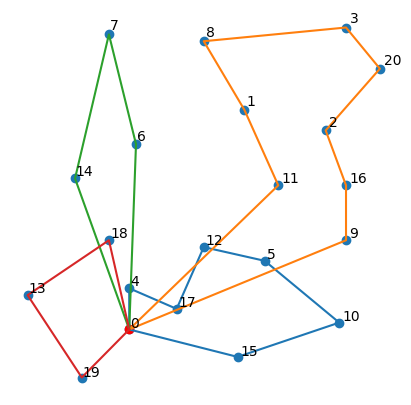

The resulting solution has a cost of: 7365.983

Trip 1 serves customers [15, 10, 5, 12, 17, 4] and uses vehicle of type 1 with fixed costs of 1500
Trip 2 serves customers [9, 16, 2, 20, 3, 8, 1, 11] and uses vehicle of type 2 with fixed costs of 3000
Trip 3 serves customers [14, 7, 6] and uses vehicle of type 0 with fixed costs of 1000
Trip 4 serves customers [19, 13, 18] and uses vehicle of type 1 with fixed costs of 1500


In [116]:
# In this cell you can try each method for a single instance of your choosing.
# The instances that work (have the correct format) are G_03, G_04, G_05, G_06, 
# G_13, G_14, G_15, G_16, G_17, G_18, G_19, G_20
# Just change the path to your desired instance and uncomment the method 
# you would like to test below. Press CTRL + Enter and results + a plot should appear

path = r"Custom-Instances\testinstances\G_06.txt"
data = readInstance(path)
instance = VFMP(data)


# CONSTRUCTION METHOD
# instance.constructSolution(k = 1, starting_node = 1)

# ILS
instance.ILS(k = 1, starting_node = 0)

# MS-ILS
# instance.MSILS(k = 2)

# Output
plotTrips(instance)

In [94]:
#--------------------------------
# LOAD SOLUTIONS FOR COMAPRISON |
#-------------------------------
solutions = {}
for i in range(1, 21):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\soluzioni\G_G_{i}.txt"
    else:
        path = fr"Custom-Instances\soluzioni\G_G_{i}.txt"
        
    try:
        data = readSolution(path)
        solutions[data["NAME"]] = data["COST"]
    except (ValueError, FileNotFoundError):
        pass
solutions

{'03°E051-05e': 961.03,
 '04°E051-05e': 6437.33,
 '05°E051-05e': 1007.05,
 '06°E051-05e': 6516.47,
 '13°E076-08s': 2408.62,
 '14°E076-08s': 9119.28,
 '15°E051-05e': 2586.37,
 '16°E051-05e': 2741.5,
 '17°E076-10e': 1749.5,
 '18°E076-10e': 2381.43,
 '19°E101-08e': 8675.16,
 '20°E101-08e': 4086.76}

In [95]:
#----------------------------------------------------------
# EXPERIMENT 1: deterministic case, k=1 for all instances |
#---------------------------------------------------------
results = {}
for i in tqdm(range(1, 21)):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
    else:
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
        
    try:
        data = readInstance(path)
        instance = VFMP(data)
        result = instance.constructSolution(k = 1)

        results[instance.name] = result
    except ValueError:
        pass
    
df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['cost', 'time'])
df.insert(2, 'optimal', solutions.values())
df.insert(3, 'gap', round((df.cost - df.optimal)/df.optimal, 3))
df.to_csv('experiment_1.csv')
df

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.76it/s]


,cost,time,optimal,gap
03°E051-05e,1018.73,0.060,961.03,0.060
04°E051-05e,6943.65,0.037,6437.33,0.079
05°E051-05e,1072.71,0.043,1007.05,0.065
06°E051-05e,7415.26,0.042,6516.47,0.138
13°E076-08s,2548.27,0.379,2408.62,0.058
14°E076-08s,9717.26,0.366,9119.28,0.066
15°E051-05e,2855.10,0.352,2586.37,0.104
16°E051-05e,2949.11,0.330,2741.50,0.076
17°E076-10e,1889.90,0.796,1749.50,0.080
18°E076-10e,2512.28,0.882,2381.43,0.055


In [96]:
#----------------------------------------------------------------------------
# EXPERIMENT 2: k=2, starting_node=depot, repetitions=20, for all instances |
#---------------------------------------------------------------------------
results = {}
for i in tqdm(range(1, 21)):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
    else:
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
        
    try:
        data = readInstance(path)
        instance = VFMP(data)
        
        repetitions = {}
        for j in range(20):
            repetitions[j] = instance.constructSolution(k = 2)

        max_cost = np.max([r[0] for r in repetitions.values()])
        mean_cost, mean_time = np.mean([[r[0], r[1]] for r in repetitions.values()], axis = 0)
        min_cost = np.min([r[0] for r in repetitions.values()])
        total_time = sum([r[1] for r in repetitions.values()])

        results[instance.name] = (max_cost, min_cost, round(mean_cost, 2), round(mean_time, 3), round(total_time, 3))
    except ValueError:
        pass

df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['max_cost', 'min_cost', 'mean_cost', 
                                                                  'mean_time', 'total_time'])
df.insert(5, 'optimal', solutions.values())
df.insert(6, 'mean_gap', round((df.mean_cost - df.optimal)/df.optimal, 3))
df.insert(7, 'min_gap', round((df.min_cost - df.optimal)/df.optimal, 3))
df.insert(8, 'max_gap', round((df.max_cost - df.optimal)/df.optimal, 3))
df.to_csv('experiment_2.csv')
df

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:41<00:00,  2.09s/it]


,max_cost,min_cost,mean_cost,mean_time,total_time,optimal,mean_gap,min_gap,max_gap
03°E051-05e,1140.97,990.63,1043.80,0.017,0.342,961.03,0.086,0.031,0.187
04°E051-05e,7462.43,6929.01,7208.66,0.017,0.346,6437.33,0.120,0.076,0.159
05°E051-05e,1149.32,1031.60,1094.06,0.020,0.395,1007.05,0.086,0.024,0.141
06°E051-05e,7910.84,6992.53,7451.62,0.014,0.280,6516.47,0.144,0.073,0.214
13°E076-08s,2638.92,2490.82,2577.87,0.123,2.468,2408.62,0.070,0.034,0.096
14°E076-08s,10277.31,9624.12,9837.92,0.089,1.786,9119.28,0.079,0.055,0.127
15°E051-05e,2966.63,2732.05,2839.95,0.091,1.810,2586.37,0.098,0.056,0.147
16°E051-05e,3148.78,2856.70,2983.88,0.096,1.915,2741.50,0.088,0.042,0.149
17°E076-10e,2036.46,1857.22,1960.44,0.242,4.834,1749.50,0.121,0.062,0.164
18°E076-10e,2715.96,2553.09,2622.13,0.291,5.814,2381.43,0.101,0.072,0.140


In [97]:
#----------------------------------------------------------------------------
# EXPERIMENT 3: k=3, starting_node=depot, repetitions=20, for all instances |
#---------------------------------------------------------------------------
results = {}
for i in tqdm(range(1, 21)):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
    else:
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
        
    try:
        data = readInstance(path)
        instance = VFMP(data)
        
        repetitions = {}
        for j in range(20):
            repetitions[j] = instance.constructSolution(k = 3)

        max_cost = np.max([r[0] for r in repetitions.values()])
        mean_cost, mean_time = np.mean([[r[0], r[1]] for r in repetitions.values()], axis = 0)
        min_cost = np.min([r[0] for r in repetitions.values()])
        total_time = sum([r[1] for r in repetitions.values()])

        results[instance.name] = (max_cost, min_cost, round(mean_cost, 2), round(mean_time, 3), round(total_time, 3))
    except ValueError:
        pass

df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['max_cost', 'min_cost', 'mean_cost', 
                                                                  'mean_time', 'total_time'])
df.insert(5, 'optimal', solutions.values())
df.insert(6, 'mean_gap', round((df.mean_cost - df.optimal)/df.optimal, 3))
df.insert(7, 'min_gap', round((df.min_cost - df.optimal)/df.optimal, 3))
df.insert(8, 'max_gap', round((df.max_cost - df.optimal)/df.optimal, 3))
df.to_csv('experiment_3.csv')
df

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.55s/it]


,max_cost,min_cost,mean_cost,mean_time,total_time,optimal,mean_gap,min_gap,max_gap
03°E051-05e,1109.40,1009.25,1066.21,0.025,0.498,961.03,0.109,0.050,0.154
04°E051-05e,7892.38,6926.24,7337.65,0.017,0.344,6437.33,0.140,0.076,0.226
05°E051-05e,1204.78,1078.78,1127.62,0.019,0.377,1007.05,0.120,0.071,0.196
06°E051-05e,7952.00,7072.02,7512.50,0.020,0.400,6516.47,0.153,0.085,0.220
13°E076-08s,2734.19,2551.36,2636.90,0.129,2.571,2408.62,0.095,0.059,0.135
14°E076-08s,10233.86,9686.99,9809.80,0.111,2.226,9119.28,0.076,0.062,0.122
15°E051-05e,2970.91,2796.23,2880.29,0.123,2.453,2586.37,0.114,0.081,0.149
16°E051-05e,3117.91,2979.79,3038.10,0.097,1.941,2741.50,0.108,0.087,0.137
17°E076-10e,2098.23,1934.07,2028.40,0.356,7.117,1749.50,0.159,0.105,0.199
18°E076-10e,2726.54,2621.63,2685.13,0.380,7.590,2381.43,0.128,0.101,0.145


In [98]:
#---------------------------------------------------------------
# EXPERIMENT 4: k=1, starting_node=all_nodes for all instances |
#--------------------------------------------------------------
results = {}
for i in tqdm(range(1, 21)):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
    else:
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
        
    try:
        data = readInstance(path)
        instance = VFMP(data)
        customers = list(instance.demands.keys())
        
        repetitions = {}
        for j in customers:
            repetitions[j] = instance.constructSolution(k = 1, starting_node = j)

        max_cost = np.max([r[0] for r in repetitions.values()])
        mean_cost, mean_time = np.mean([[r[0], r[1]] for r in repetitions.values()], axis = 0)
        min_cost = np.min([r[0] for r in repetitions.values()])
        total_time = sum([r[1] for r in repetitions.values()])

        results[instance.name] = (max_cost, min_cost, round(mean_cost, 2), round(mean_time, 3), round(total_time, 3))
    except ValueError:
        pass

df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['max_cost', 'min_cost', 'mean_cost', 
                                                                  'mean_time', 'total_time'])
df.insert(5, 'optimal', solutions.values())
df.insert(6, 'mean_gap', round((df.mean_cost - df.optimal)/df.optimal, 3))
df.insert(7, 'min_gap', round((df.min_cost - df.optimal)/df.optimal, 3))
df.insert(8, 'max_gap', round((df.max_cost - df.optimal)/df.optimal, 3))
df.to_csv('experiment_4.csv')
df

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:59<00:00,  8.97s/it]


,max_cost,min_cost,mean_cost,mean_time,total_time,optimal,mean_gap,min_gap,max_gap
03°E051-05e,1053.76,1003.98,1020.32,0.015,0.313,961.03,0.062,0.045,0.096
04°E051-05e,7872.94,6924.24,7317.87,0.011,0.234,6437.33,0.137,0.076,0.223
05°E051-05e,1114.60,1045.87,1080.29,0.013,0.281,1007.05,0.073,0.039,0.107
06°E051-05e,7475.70,7006.22,7249.35,0.016,0.338,6516.47,0.112,0.075,0.147
13°E076-08s,2588.22,2465.60,2532.77,0.114,5.820,2408.62,0.052,0.024,0.075
14°E076-08s,9730.18,9599.87,9666.80,0.125,6.388,9119.28,0.060,0.053,0.067
15°E051-05e,2888.96,2675.32,2801.29,0.130,6.619,2586.37,0.083,0.034,0.117
16°E051-05e,2996.49,2884.40,2950.51,0.123,6.287,2741.50,0.076,0.052,0.093
17°E076-10e,1959.49,1837.33,1893.34,0.270,20.523,1749.50,0.082,0.050,0.120
18°E076-10e,2603.28,2475.21,2530.31,0.325,24.697,2381.43,0.063,0.039,0.093


In [100]:
#----------------------------------------------------------
# EXPERIMENT 5: deterministic case, no local search for all instances |
#---------------------------------------------------------
results = {}
for i in tqdm(range(1, 21)):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
    else:
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
        
    try:
        data = readInstance(path)
        instance = VFMP(data)
        result = instance.constructSolutionNoLocalSearch(k = 1)

        results[instance.name] = result
    except ValueError:
        pass
    
df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['cost', 'time'])
df.insert(2, 'optimal', solutions.values())
df.insert(3, 'gap', round((df.cost - df.optimal)/df.optimal, 3))
df.to_csv('experiment_5.csv')
df

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.68it/s]


,cost,time,optimal,gap
03°E051-05e,1029.66,0.003,961.03,0.071
04°E051-05e,6947.37,0.004,6437.33,0.079
05°E051-05e,1103.11,0.003,1007.05,0.095
06°E051-05e,7449.06,0.004,6516.47,0.143
13°E076-08s,2553.16,0.011,2408.62,0.060
14°E076-08s,9739.78,0.024,9119.28,0.068
15°E051-05e,2889.22,0.028,2586.37,0.117
16°E051-05e,2973.74,0.019,2741.50,0.085
17°E076-10e,1940.36,0.028,1749.50,0.109
18°E076-10e,2553.75,0.054,2381.43,0.072


In [101]:
#----------------------------------------------------------------------------------------------------------
# EXPERIMENT 6: ILS = Initial Solution -> Concat -> Improve Giant Tour -> Split -> Local Search -> Repeat |
#---------------------------------------------------------------------------------------------------------
results = {}
for i in tqdm(range(1, 21)):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
    else:
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
        
    try:
        data = readInstance(path)
        instance = VFMP(data)
        result = instance.ILS()

        results[instance.name] = result
    except ValueError:
        pass

df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['cost', 'time'])
df.insert(2, 'optimal', solutions.values())
df.insert(3, 'gap', round((df.cost - df.optimal)/df.optimal, 3))
df.to_csv('experiment_6.csv')
df

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.48s/it]


,cost,time,optimal,gap
03°E051-05e,978.93,0.394,961.03,0.019
04°E051-05e,6943.65,0.359,6437.33,0.079
05°E051-05e,1010.12,0.379,1007.05,0.003
06°E051-05e,7365.98,0.446,6516.47,0.130
13°E076-08s,2424.63,3.198,2408.62,0.007
14°E076-08s,9598.71,3.456,9119.28,0.053
15°E051-05e,2698.61,3.270,2586.37,0.043
16°E051-05e,2831.02,3.086,2741.50,0.033
17°E076-10e,1796.63,6.489,1749.50,0.027
18°E076-10e,2431.96,9.130,2381.43,0.021


In [102]:
#----------------------------------------
# EXPERIMENT 7: MSILS = Multi-Start ILS |
#---------------------------------------
results = {}
for i in tqdm(range(1, 21)):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
    else:
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
        
    try:
        
        data = readInstance(path)
        instance = VFMP(data)
        result = instance.MSILS()

        results[instance.name] = result
    except ValueError:
        pass

df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['cost', 'time'])
df.insert(2, 'optimal', solutions.values())
df.insert(3, 'gap', round((df.cost - df.optimal)/df.optimal, 3))
df.to_csv('experiment_7.csv')
df

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [17:04<00:00, 51.23s/it]


,cost,time,optimal,gap
03°E051-05e,961.03,6.465,961.03,0.000
04°E051-05e,6899.08,4.445,6437.33,0.072
05°E051-05e,1010.12,6.806,1007.05,0.003
06°E051-05e,6997.96,6.094,6516.47,0.074
13°E076-08s,2422.00,48.648,2408.62,0.006
14°E076-08s,9120.35,52.656,9119.28,0.000
15°E051-05e,2639.39,52.047,2586.37,0.020
16°E051-05e,2798.17,41.721,2741.50,0.021
17°E076-10e,1778.11,98.988,1749.50,0.016
18°E076-10e,2428.03,137.575,2381.43,0.020


In [103]:
#-----------------------------------------------------------------
# EXPERIMENT 8: MSILS = Multi-Start ILS, lot of starts, few iters|
#----------------------------------------------------------------
results = {}
for i in tqdm(range(1, 21)):
    if i < 10:
        i = f'0{i}'
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
    else:
        path = fr"Custom-Instances\testinstances\G_{i}.txt"
        
    try:
        
        data = readInstance(path)
        instance = VFMP(data)
        result = instance.MSILS(iters = 5, starts = 25)

        results[instance.name] = result
    except ValueError:
        pass

df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['cost', 'time'])
df.insert(2, 'optimal', solutions.values())
df.insert(3, 'gap', round((df.cost - df.optimal)/df.optimal, 3))
df.to_csv('experiment_8.csv')
df

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:05<00:00, 24.28s/it]


,cost,time,optimal,gap
03°E051-05e,961.03,3.265,961.03,0.000
04°E051-05e,6892.14,2.642,6437.33,0.071
05°E051-05e,1010.12,3.003,1007.05,0.003
06°E051-05e,6995.71,2.629,6516.47,0.074
13°E076-08s,2424.45,24.599,2408.62,0.007
14°E076-08s,9172.41,21.703,9119.28,0.006
15°E051-05e,2670.97,23.317,2586.37,0.033
16°E051-05e,2809.23,21.812,2741.50,0.025
17°E076-10e,1798.58,47.927,1749.50,0.028
18°E076-10e,2447.17,63.090,2381.43,0.028
